# Improving Language Understanding by Generative Pre-Training
### 授课老师：Yamada
# 1 前言
## 1.1课程回顾


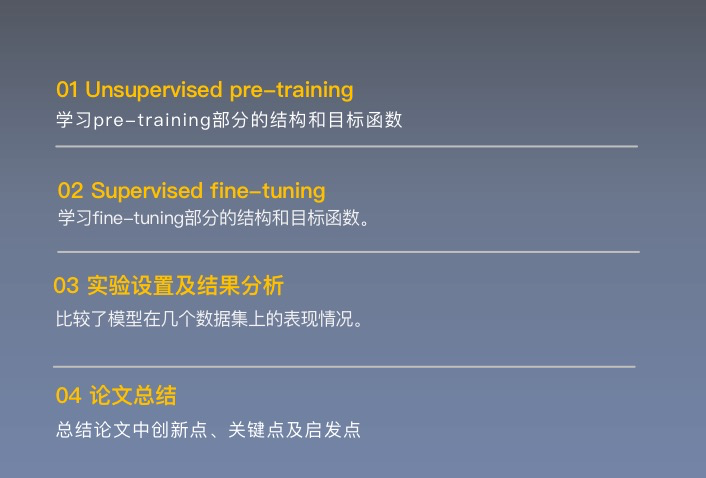

# 1.2 本课知识树
<img src="images/WechatIMG102.jpeg"  width="300" height="500" align="left"  />
<img src="images/WechatIMG103.jpeg"  width="400" height="800" align="right" />

# 2 准备工作
## 2.1项目环境配置



* Python3.7
* jupyter notebook
* torch           1.2.0+cu92
* torchsummary    1.5.1
* sklearn      1.4.3





# 2.2 数据集下载
　　 #训练数据在data文件夹下
    #https://codeload.github.com/openai/finetune-transformer-lm/zip/master 预训练模型

# 3 项目代码结构（pycharm中演示）

# 4 算法模块及细节（jupyter和pycharm中演示）

# ===========参数arg=============

In [15]:
class Args():
    def __init__(self):
        self.dataset="/Users/liubo22/Downloads/"
        self.log_dir="log/"
        self.save_dir="save/"
        #data_dir 就是数据的路径，需要修改成自己的路径
        self.data_dir='./data/'
        self.submission_dir="submission/"
        self.submit=True
        self.analysis=True
        self.seed=42
        self.n_iter=3
        self.n_batch=8
        self.max_grad_norm=1
        self.lr=6.25e-5
        self.lr_warmup=0.002
        self.n_ctx=512
        self.n_embd=768
        self.n_layer=12
        self.n_head=12
        self.embd_pdrop=0.1
        self.attn_pdrop=0.1
        self.resid_pdrop=0.1
        self.clf_pdrop=0.1
        self.l2=0.01
        self.vector_l2=True
        self.opt='adam'
        self.afn='gelu'
        self.lr_schedule='warmup_linear'
        #预训练文件的路径,需要自己修改
        self.encoder_path='../finetune-transformer-lm-master/model/encoder_bpe_40000.json'
        self.bpe_path='../finetune-transformer-lm-master/model/vocab_40000.bpe'
        self.n_transfer=12
        self.lm_coef=0.5
        self.b1=0.9
        self.b2=0.999
        self.e=1e-8
        self.n_valid=374
        self.desc='rocstories'


In [16]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
args=Args()
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

# Constants
submit = args.submit
dataset = args.dataset
n_ctx = args.n_ctx
save_dir = args.save_dir
desc = args.desc
data_dir = args.data_dir
log_dir = args.log_dir
submission_dir = args.submission_dir

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("device", device, "n_gpu", n_gpu)

device cpu n_gpu 0


# ======================预处理==================

In [17]:
import re
import ftfy
import json
import spacy

from tqdm import tqdm
class TextEncoder(object):
    """
    mostly a wrapper for a public python bpe tokenizer
    """

    def __init__(self, encoder_path, bpe_path):
        self.nlp = spacy.load('en', disable=['parser', 'tagger', 'ner', 'textcat'])
        self.encoder = json.load(open(encoder_path))#encoder_bpe_400000.json
        self.decoder = {v:k for k,v in self.encoder.items()}
        merges = open(bpe_path, encoding='utf-8').read().split('\n')[1:-1]#vocab_40000.bpe
        merges = [tuple(merge.split()) for merge in merges]
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {}

    def bpe(self, token):
        #movie--->（m,o,v,i,e</w>）
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        if token in self.cache:
            return self.cache[token]
        
        #(t,o</w>)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            #{('m','o'),('o','v'),('v','i'),('i','e</w>')}===>('m','o')
            ##{('mo','v'),('v','i'),('i','e</w>')}===>('v','i')
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                #first=‘m’|'v'
                #second='o'|'i'
                try:
                    #更新一次后，word变成(mo,v,i,e</w>) j=1 i=1
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    #new_word=['mo','v','i','e</w>']|更新后new_word=['mo','vi','e</w>']
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    #new_word.append('mo')  i=2|更新后 new_word.append('vi') i=3
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                #{('mo','v'),('v','i'),('i','e</w>')}
                pairs = get_pairs(word)
        word = ' '.join(word)
        if word == '\n  </w>':
            word = '\n</w>'
        self.cache[token] = word
        return word

    def encode(self, texts, verbose=True):
        texts_tokens = []
        if verbose:
            for text in tqdm(texts, ncols=80, leave=False):
                text = self.nlp(text_standardize(ftfy.fix_text(text)))
                text_tokens = []
                for token in text:
                    text_tokens.extend([self.encoder.get(t, 0) for t in self.bpe(token.text.lower()).split(' ')])
                texts_tokens.append(text_tokens)
        else:
            for text in texts:
                text = self.nlp(text_standardize(ftfy.fix_text(text)))
                text_tokens = []
                for token in text:
                    text_tokens.extend([self.encoder.get(t, 0) for t in self.bpe(token.text.lower()).split(' ')])
                texts_tokens.append(text_tokens)
        return texts_tokens

def get_pairs(word):
    """
    Return set of symbol pairs in a word.
    word is represented as tuple of symbols (symbols being variable-length strings)
    """
    pairs = set()#{('m','o'),('o','v'),('v','i'),('i','e</w>')}
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

def text_standardize(text):
    """
    fixes some issues the spacy tokenizer had on books corpus
    also does some whitespace standardization
    """
    text = text.replace('—', '-')
    text = text.replace('–', '-')
    text = text.replace('―', '-')
    text = text.replace('…', '...')
    text = text.replace('´', "'")
    text = re.sub(r'''(-+|~+|!+|"+|;+|\?+|\++|,+|\)+|\(+|\\+|\/+|\*+|\[+|\]+|}+|{+|\|+|_+)''', r' \1 ', text)
    text = re.sub(r'\s*\n\s*', ' \n ', text)
    text = re.sub(r'[^\S\n]+', ' ', text)
    return text.strip()


text_encoder = TextEncoder(args.encoder_path, args.bpe_path)
encoder = text_encoder.encoder
n_vocab = len(text_encoder.encoder)

In [18]:
import os
import csv
import numpy as np

from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

seed = 3535999445

def _rocstories(path):
    with open(path, encoding='utf_8') as f:
        f = csv.reader(f)
        st = []#存储的context
        ct1 = []#存储的choice1
        ct2 = []#存储的choice2
        y = []#label
        for i, line in enumerate(tqdm(list(f), ncols=80, leave=False)):
            if i > 0:
                s = ' '.join(line[1:5])
                c1 = line[5]
                c2 = line[6]
                st.append(s)
                ct1.append(c1)
                ct2.append(c2)
                y.append(int(line[-1])-1)
        return st, ct1, ct2, y
    
def rocstories(data_dir, n_train=1497, n_valid=374):
    storys, comps1, comps2, ys = _rocstories(os.path.join(data_dir, 'cloze_test_val__spring2016 - cloze_test_ALL_val.csv'))
    teX1, teX2, teX3, _ = _rocstories(os.path.join(data_dir, 'cloze_test_test__spring2016 - cloze_test_ALL_test.csv'))
    tr_storys, va_storys, tr_comps1, va_comps1, tr_comps2, va_comps2, tr_ys, va_ys = train_test_split(storys, comps1, comps2, ys, test_size=n_valid, random_state=seed)
    trX1, trX2, trX3 = [], [], []
    trY = []
    for s, c1, c2, y in zip(tr_storys, tr_comps1, tr_comps2, tr_ys):
        trX1.append(s)
        trX2.append(c1)
        trX3.append(c2)
        trY.append(y)

    vaX1, vaX2, vaX3 = [], [], []
    vaY = []
    for s, c1, c2, y in zip(va_storys, va_comps1, va_comps2, va_ys):
        vaX1.append(s)
        vaX2.append(c1)
        vaX3.append(c2)
        vaY.append(y)
    trY = np.asarray(trY, dtype=np.int32)
    vaY = np.asarray(vaY, dtype=np.int32)
    return (trX1, trX2, trX3, trY), (vaX1, vaX2, vaX3, vaY), (teX1, teX2, teX3)

def encode_dataset(*splits, encoder):
    encoded_splits = []
    for split in splits:#split[0]=(trX1, trX2, trX3, trY)
        fields = []
        for field in split:#filed=trX1
            if isinstance(field[0], str):
                field = encoder.encode(field)
            fields.append(field)
        encoded_splits.append(fields)
    return encoded_splits

print("Encoding dataset...")
#*代表参数以tuple的形式传入
((trX1, trX2, trX3, trY),
 (vaX1, vaX2, vaX3, vaY),
 (teX1, teX2, teX3)) = encode_dataset(*rocstories(data_dir, n_valid=args.n_valid),
                                      encoder=text_encoder)

encoder['_start_'] = len(encoder)
encoder['_delimiter_'] = len(encoder)
encoder['_classify_'] = len(encoder)
clf_token = encoder['_classify_']

n_special = 3
max_len = n_ctx // 2 - 2
n_ctx = min(max(
    [len(x1[:max_len]) + max(len(x2[:max_len]),
                             len(x3[:max_len])) for x1, x2, x3 in zip(trX1, trX2, trX3)]
    + [len(x1[:max_len]) + max(len(x2[:max_len]),
                               len(x3[:max_len])) for x1, x2, x3 in zip(vaX1, vaX2, vaX3)]
    + [len(x1[:max_len]) + max(len(x2[:max_len]),
                               len(x3[:max_len])) for x1, x2, x3 in zip(teX1, teX2, teX3)]
    ) + 3, n_ctx)
vocab = n_vocab + n_special + n_ctx

  4%|█▌                                      | 60/1497 [00:00<00:02, 595.21it/s]

Encoding dataset...


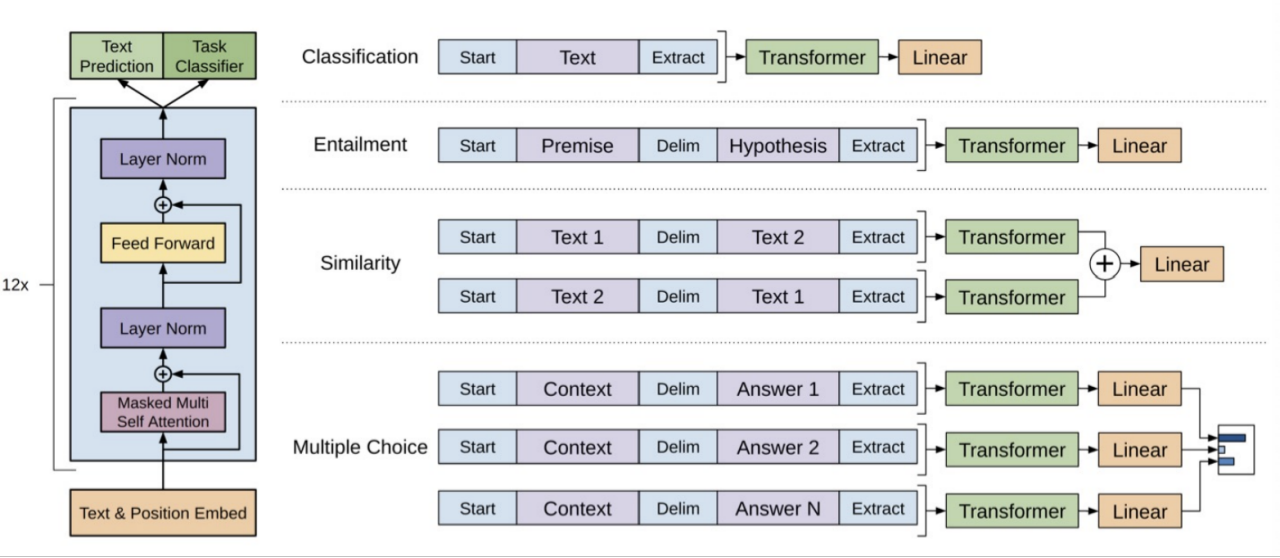

In [19]:
def transform_roc(X1, X2, X3):
    n_batch = len(X1)
    xmb = np.zeros((n_batch, 2, n_ctx, 2), dtype=np.int32)#[1497,2,77,2]
    mmb = np.zeros((n_batch, 2, n_ctx), dtype=np.float32)#[1497,2,77]
    start = encoder['_start_']
    delimiter = encoder['_delimiter_']
    for i, (x1, x2, x3), in enumerate(zip(X1, X2, X3)):#max_len=254
        x12 = [start] + x1[:max_len] + [delimiter] + x2[:max_len] + [clf_token]
        x13 = [start] + x1[:max_len] + [delimiter] + x3[:max_len] + [clf_token]
        l12 = len(x12)
        l13 = len(x13)
        #xmb[0][0]=[[40478     0], [  249     0], [ 1925     0]]
        xmb[i, 0, :l12, 0] = x12
        xmb[i, 1, :l13, 0] = x13
        mmb[i, 0, :l12] = 1
        mmb[i, 1, :l13] = 1
    # Position information that is added to the input embeddings in the TransformerModel
    #xmb[0][0]=[[40478 40481], [  249 40482], [ 1925 40483]]
    xmb[:, :, :, 1] = np.arange(n_vocab + n_special, n_vocab + n_special + n_ctx)
    return xmb, mmb

vocab = n_vocab + n_special + n_ctx
trX, trM = transform_roc(trX1, trX2, trX3)
vaX, vaM = transform_roc(vaX1, vaX2, vaX3)
if submit:
    teX, teM = transform_roc(teX1, teX2, teX3)
    
n_train = len(trY)
n_valid = len(vaY)
n_batch_train = args.n_batch * max(n_gpu, 1)
n_updates_total = (n_train // n_batch_train) * args.n_iter

# =========模型结构=========

In [20]:
import copy
import json
import math
import re
import collections

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter


def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


def swish(x):
    return x * torch.sigmoid(x)


ACT_FNS = {
    'relu': nn.ReLU,
    'swish': swish,
    'gelu': gelu
}

#===========Layer Normalization============
class LayerNorm(nn.Module):
    "Construct a layernorm module in the OpenAI style (epsilon inside the square root)."

    def __init__(self, n_state, e=1e-5):
        super(LayerNorm, self).__init__()
        self.g = nn.Parameter(torch.ones(n_state))
        self.b = nn.Parameter(torch.zeros(n_state))
        self.e = e

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.e)
        return self.g * x + self.b

#===============这里的卷积是在transformer里为线性层=======
class Conv1D(nn.Module):
    def __init__(self, nf, rf, nx):
        super(Conv1D, self).__init__()
        self.rf = rf
        self.nf = nf
        if rf == 1:  # faster 1x1 conv
            w = torch.empty(nx, nf)
            nn.init.normal_(w, std=0.02)
            self.w = Parameter(w)#[768,2304]
            self.b = Parameter(torch.zeros(nf))
        else:  # was used to train LM
            raise NotImplementedError

    def forward(self, x):
        #[16,77,768]
        if self.rf == 1:
            size_out = x.size()[:-1] + (self.nf,)
            x = torch.addmm(self.b, x.view(-1, x.size(-1)), self.w)
            x = x.view(*size_out)#[16,77,2304]
        else:
            raise NotImplementedError
        return x
    

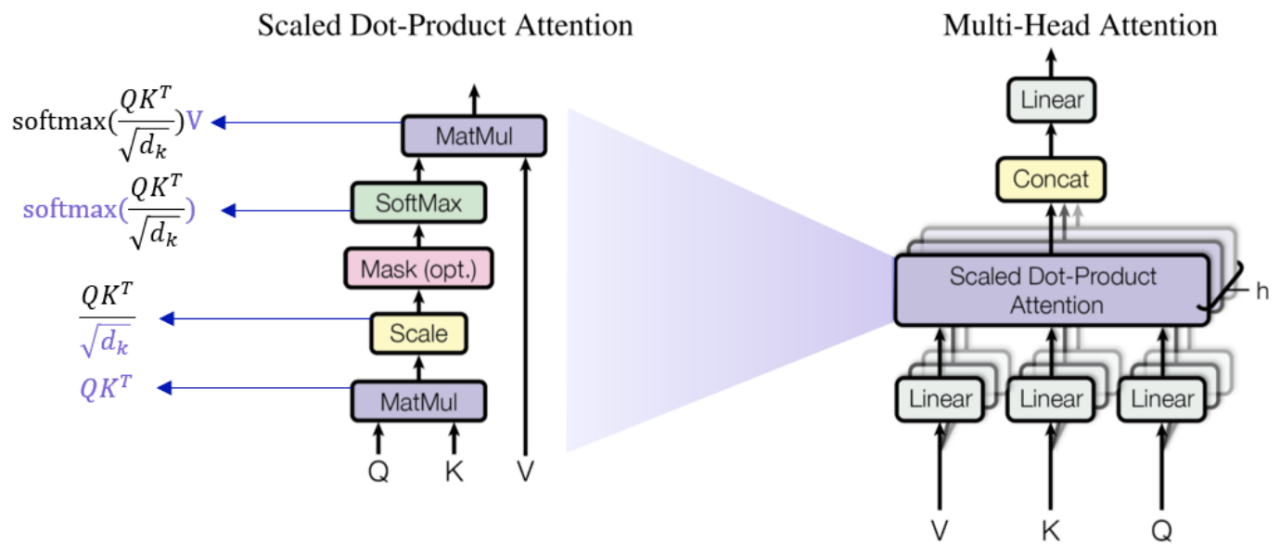

In [21]:
class Attention(nn.Module):
    def __init__(self, nx, n_ctx, cfg, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        # [switch nx => n_state from Block to Attention to keep identical to TF implem]
        assert n_state % cfg.n_head == 0
        self.register_buffer('b', torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = cfg.n_head#12
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, 1, nx)#(768*3,1,768)
        self.c_proj = Conv1D(n_state, 1, nx)#(768,1,768)
        self.attn_dropout = nn.Dropout(cfg.attn_pdrop)
        self.resid_dropout = nn.Dropout(cfg.resid_pdrop)

    def _attn(self, q, k, v):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))#[16,12,77,77]
        # w = w * self.b + -1e9 * (1 - self.b)  # TF implem method: mask_attn_weights
        # XD: self.b may be larger than w, so we need to crop it
        b = self.b[:, :, :w.size(-2), :w.size(-1)]#[1,1,77,77]
        w = w * b + -1e9 * (1 - b)

        w = nn.Softmax(dim=-1)(w)
        w = self.attn_dropout(w)
        return torch.matmul(w, v)

    def merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)  # in Tensorflow implem: fct merge_states

    def split_heads(self, x, k=False):
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)  # in Tensorflow implem: fct split_states
        #[16,77,12,64]
        if k:
            return x.permute(0, 2, 3, 1)
        else:
            return x.permute(0, 2, 1, 3)

    def forward(self, x):
        #[16,77,768]
        x = self.c_attn(x)
        #q=k=v=[16,77,768]
        query, key, value = x.split(self.split_size, dim=2)
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)
        a = self._attn(query, key, value)
        a = self.merge_heads(a)
        a = self.c_proj(a)
        a = self.resid_dropout(a)
        return a

In [22]:
class MLP(nn.Module):
    def __init__(self, n_state, cfg):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = cfg.n_embd
        self.c_fc = Conv1D(n_state, 1, nx)#(4*768,768)
        self.c_proj = Conv1D(nx, 1, n_state)#(768,4*768)
        self.act = ACT_FNS[cfg.afn]
        self.dropout = nn.Dropout(cfg.resid_pdrop)

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        return self.dropout(h2)
    
class Block(nn.Module):
    def __init__(self, n_ctx, cfg, scale=False):
        super(Block, self).__init__()
        nx = cfg.n_embd
        self.attn = Attention(nx, n_ctx, cfg, scale)
        self.ln_1 = LayerNorm(nx)
        self.mlp = MLP(4 * nx, cfg)
        self.ln_2 = LayerNorm(nx)

    def forward(self, x):
        a = self.attn(x)
        n = self.ln_1(x + a)
        m = self.mlp(n)
        h = self.ln_2(n + m)
        return h

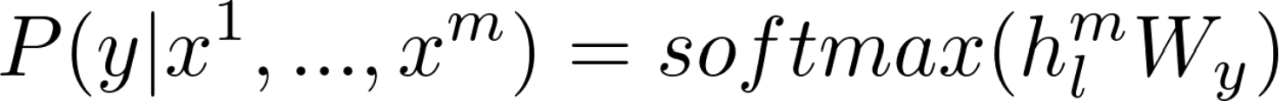

In [23]:
class TransformerModel(nn.Module):
    """ Transformer model """

    def __init__(self, cfg, vocab=40990, n_ctx=512):
        super(TransformerModel, self).__init__()
        self.vocab = vocab#40558
        self.embed = nn.Embedding(vocab, cfg.n_embd)#[40558,768]
        self.drop = nn.Dropout(cfg.embd_pdrop)
        block = Block(n_ctx, cfg, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(cfg.n_layer)])

        nn.init.normal_(self.embed.weight, std=0.02)

    def forward(self, x):
        #[8,2,77,2]=>[16,77,2]
        x = x.view(-1, x.size(-2), x.size(-1))
        #[16,77,2,768]
        e = self.drop(self.embed(x))
        # Add the position information to the input embeddings
        #[16,77.768]
        h = e.sum(dim=2)
        for block in self.h:
            h = block(h)
        return h
    
class LMHead(nn.Module):
    """ Language Model Head for the transformer """

    def __init__(self, model, cfg, trunc_and_reshape=True):
        super(LMHead, self).__init__()
        self.n_embd = cfg.n_embd
        embed_shape = model.embed.weight.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)#768,40558
        self.decoder.weight = model.embed.weight # Tied weights
        self.trunc_and_reshape = trunc_and_reshape  # XD

    def forward(self, h):
        #[16,77,768]  h[:,:-1]=[16,76,768]
        # Truncated Language modeling logits (we remove the last token)
        h_trunc = h[:, :-1].contiguous().view(-1, self.n_embd) \
            if self.trunc_and_reshape else h  # XD   [1216,768]
        lm_logits = self.decoder(h_trunc)[1216,40558]
        return lm_logits

In [24]:
class MultipleChoiceHead(nn.Module):
    """ Classifier Head for the transformer """

    def __init__(self, clf_token, cfg):
        super(MultipleChoiceHead, self).__init__()
        self.n_embd = cfg.n_embd#768
        self.clf_token = clf_token#40480
        self.dropout = nn.Dropout2d(cfg.clf_pdrop)  # To reproduce the noise_shape parameter of TF implementation
        self.linear = nn.Linear(cfg.n_embd, 1)

        nn.init.normal_(self.linear.weight, std = 0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, h, x):
        #[16,77,768] [8,2,77,2] 
        # Classification logits
        clf_h = h.view(-1, self.n_embd)#(1232,768)
        flat = x[..., 0].contiguous().view(-1)#x[...,0]=[8,2,77]--.1232
        clf_h = clf_h[flat == self.clf_token, :]
        clf_h = clf_h.view(-1, x.size(1), self.n_embd, 1)
        # This double transposition is there to replicate the behavior
        # of the noise_shape argument in the tensorflow
        # implementation.  For more details, see
        # https://github.com/huggingface/pytorch-openai-transformer-lm/issues/11
        clf_h = self.dropout(clf_h.transpose(1, 2)).transpose(1, 2)
        clf_h = clf_h.contiguous().view(-1, self.n_embd)
        clf_logits = self.linear(clf_h)

        return clf_logits.view(-1, x.size(1))

In [25]:
class DoubleHeadModel(nn.Module):
    """ Transformer with language model and task specific heads """
    def __init__(self, cfg, clf_token, task_head_type, vocab=40990, n_ctx=512):
        super(DoubleHeadModel, self).__init__()
        self.transformer = TransformerModel(cfg, vocab=vocab, n_ctx=n_ctx)
        self.lm_head = LMHead(self.transformer, cfg)
        if isinstance(task_head_type, str):
            if task_head_type == 'multiple_choice':
                self.task_head = MultipleChoiceHead(clf_token, cfg)
            else:
                raise ValueError("task_head_type is expected to be 'multiple_choice' "
                                 "'similarity', 'inference' or ('classification', n_class) "
                                 f"got {task_head_type}.")
        else:
            raise ValueError("task_head_type is expected to be 'multiple_choice' "
                             "'similarity', 'inference' or ('classification', n_class) "
                             f"got {task_head_type}.")

    def forward(self, x):
        #[8,2,77,2]
        h = self.transformer(x)
        lm_logits = self.lm_head(h)
        task_logits = self.task_head(h, x)

        return lm_logits, task_logits
    
dh_model = DoubleHeadModel(args, clf_token, 'multiple_choice', vocab, n_ctx)

# =============优化器============

In [26]:
import math
import torch
from torch.optim import Optimizer
from torch.nn.utils import clip_grad_norm_

def warmup_cosine(x, warmup=0.002):
    s = 1 if x <= warmup else 0
    return s*(x/warmup) + (1-s)*(0.5 * (1 + torch.cos(math.pi * x)))

def warmup_constant(x, warmup=0.002):
    s = 1 if x <= warmup else 0
    return s*(x/warmup) + (1-s)*1

def warmup_linear(x, warmup=0.002):
    s = 1 if x <= warmup else 0
    return (s*(x/warmup) + (1-s))*(1-x)

SCHEDULES = {
    'warmup_cosine':warmup_cosine,
    'warmup_constant':warmup_constant,
    'warmup_linear':warmup_linear,
}


class OpenAIAdam(Optimizer):
    """Implements Open AI version of Adam algorithm with weight decay fix.
    """
    def __init__(self, params, lr, schedule, warmup, t_total,
                 b1=0.9, b2=0.999, e=1e-8, l2=0,
                 vector_l2=False, max_grad_norm=-1, **kwargs):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if schedule not in SCHEDULES:
            raise ValueError("Invalid schedule parameter: {}".format(schedule))
        if not 0 <= warmup:
            raise ValueError("Invalid warmup: {}".format(warmup))
        if not 0.0 <= b1 < 1.0:
            raise ValueError("Invalid b1 parameter: {}".format(b1))
        if not 0.0 <= b2 < 1.0:
            raise ValueError("Invalid b2 parameter: {}".format(b2))
        if not 0.0 <= e:
            raise ValueError("Invalid epsilon value: {}".format(e))
        defaults = dict(lr=lr, schedule=schedule, warmup=warmup, t_total=t_total,
                        b1=b1, b2=b2, e=e, l2=l2, vector_l2=vector_l2,
                        max_grad_norm=max_grad_norm)
        super(OpenAIAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['b1'], group['b2']

                state['step'] += 1

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['e'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                schedule_fct = SCHEDULES[group['schedule']]
                lr_scheduled = group['lr'] * schedule_fct(state['step']/group['t_total'], group['warmup'])
                step_size = lr_scheduled * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                # Add weight decay at the end (fixed version)
                if (len(p.size()) > 1 or group['vector_l2']) and group['l2'] > 0:
                    p.data.add_(-lr_scheduled * group['l2'], p.data)

        return loss
    
model_opt = OpenAIAdam(dh_model.parameters(),
                       lr=args.lr,
                       schedule=args.lr_schedule,
                       warmup=args.lr_warmup,
                       t_total=n_updates_total,
                       b1=args.b1,
                       b2=args.b2,
                       e=args.e,
                       l2=args.l2,
                       vector_l2=args.vector_l2,
                       max_grad_norm=args.max_grad_norm)

# =========计算损失===========

In [27]:
criterion = nn.CrossEntropyLoss(reduce=False)

class MultipleChoiceLossCompute:
    "A Loss compute and train function for multiple choice tasks."

    def __init__(self, lm_criterion, clf_criterion, lm_coef, opt=None):
        self.lm_criterion = lm_criterion
        self.clf_criterion = clf_criterion
        self.lm_coef = lm_coef
        self.opt = opt

    def __call__(self, X, Y, M, clf_logits, lm_logits=None, only_return_losses=False):
        # Language modeling loss
        if lm_logits is not None:
            x_shifted = X[:, :, 1:, 0].contiguous().view(-1)  # Shape: 252
            M = M.view(-1, M.size(2))
            lm_losses = self.lm_criterion(lm_logits, x_shifted)
            lm_losses = lm_losses.view(X.size(0) * X.size(1), X.size(2) - 1)
            lm_losses = lm_losses * M[:, 1:]
            lm_losses = lm_losses.sum(1) / torch.sum(M[:, 1:], 1)
        # Classification loss
        clf_losses = self.clf_criterion(clf_logits, Y)
        if only_return_losses:
            return (clf_losses, lm_losses) if lm_logits is not None else clf_losses

        if self.lm_coef > 0 and lm_logits is not None:
            train_loss = clf_losses.sum() + self.lm_coef * lm_losses.sum()
        else:
            train_loss = clf_losses.sum()
        train_loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.zero_grad()
        return train_loss.item()

compute_loss_fct = MultipleChoiceLossCompute(criterion,
                                                 criterion,
                                                 args.lm_coef,
                                                 model_opt)

/usr/local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


# =============加载预训练==========

In [28]:
def load_openai_pretrained_model(model, n_ctx=-1, n_special=-1, n_transfer=12, n_embd=768, path='./model/',
                                 path_names='./'):
    # Load weights from TF model
    print("Loading weights...")
    names = json.load(open(path_names + 'parameters_names.json'))
    shapes = json.load(open(path + 'params_shapes.json'))
    offsets = np.cumsum([np.prod(shape) for shape in shapes])
    init_params = [np.load(path + 'params_{}.npy'.format(n)) for n in range(10)]
    init_params = np.split(np.concatenate(init_params, 0), offsets)[:-1]
    init_params = [param.reshape(shape) for param, shape in zip(init_params, shapes)]
    if n_ctx > 0:
        init_params[0] = init_params[0][:n_ctx]
    if n_special > 0:
        init_params[0] = np.concatenate(
            [init_params[1],
             (np.random.randn(n_special, n_embd) * 0.02).astype(np.float32),
             init_params[0]
             ], 0)
    else:
        init_params[0] = np.concatenate(
            [init_params[1],
             init_params[0]
             ], 0)
    del init_params[1]
    if n_transfer == -1:
        n_transfer = 0
    else:
        n_transfer = 1 + n_transfer * 12
    init_params = [arr.squeeze() for arr in init_params]

    try:
        assert model.embed.weight.shape == init_params[0].shape
    except AssertionError as e:
        e.args += (model.embed.weight.shape, init_params[0].shape)
        raise

    model.embed.weight.data = torch.from_numpy(init_params[0])

    for name, ip in zip(names[1:n_transfer], init_params[1:n_transfer]):
        name = name[6:]  # skip "model/"
        assert name[-2:] == ":0"
        name = name[:-2]
        name = name.split('/')
        pointer = model
        for m_name in name:
            if re.fullmatch(r'[A-Za-z]+\d+', m_name):
                l = re.split(r'(\d+)', m_name)
            else:
                l = [m_name]
            pointer = getattr(pointer, l[0])
            if len(l) >= 2:
                num = int(l[1])
                pointer = pointer[num]
        try:
            assert pointer.shape == ip.shape
        except AssertionError as e:
            e.args += (pointer.shape, ip.shape)
            raise
        pointer.data = torch.from_numpy(ip)
        
load_openai_pretrained_model(dh_model.transformer, n_ctx=n_ctx, n_special=n_special,path=data_dir+'finetune-transformer-lm-master/model/')

Loading weights...


FileNotFoundError: [Errno 2] No such file or directory: './parameters_names.json'

# =============main===========

In [ ]:
dh_model.to(device)
dh_model = nn.DataParallel(dh_model)

n_updates = 0
n_epochs = 0
if dataset != 'stsb':
    trYt = trY
if submit:
    path = os.path.join(save_dir, desc, 'best_params')
    torch.save(dh_model.state_dict(), make_path(path))
best_score = 0

def run_epoch():
    for xmb, mmb, ymb in iter_data(*shuffle(trX, trM, trYt, random_state=np.random),
                                   n_batch=n_batch_train, truncate=True, verbose=True):
        global n_updates
        dh_model.train()
        XMB = torch.tensor(xmb, dtype=torch.long).to(device)#[8,2,77,2]
        YMB = torch.tensor(ymb, dtype=torch.long).to(device)#[8]
        MMB = torch.tensor(mmb).to(device)#[8,2,77]
        lm_logits, clf_logits = dh_model(XMB)
        compute_loss_fct(XMB, YMB, MMB, clf_logits, lm_logits)
        n_updates += 1
#         if n_updates in [1000, 2000, 4000, 8000, 16000, 32000] and n_epochs == 0:
#             log(save_dir, desc)
            
for i in range(args.n_iter):
    print("running epoch", i)
    run_epoch()
    n_epochs += 1
    
def iter_predict(Xs, Ms):
    logits = []
    with torch.no_grad():
        dh_model.eval()
        for xmb, mmb in iter_data(Xs, Ms, n_batch=n_batch_train, truncate=False, verbose=True):
            n = len(xmb)
            XMB = torch.tensor(xmb, dtype=torch.long).to(device)
            MMB = torch.tensor(mmb).to(device)
            _, clf_logits = dh_model(XMB)
            logits.append(clf_logits.to("cpu").numpy())
    logits = np.concatenate(logits, 0)
    return logits

def predict(dataset, submission_dir):
    filename = filenames[dataset]
    pred_fn = pred_fns[dataset]
    label_decoder = label_decoders[dataset]
    predictions = pred_fn(iter_predict(teX, teM))
    if label_decoder is not None:
        predictions = [label_decoder[prediction] for prediction in predictions]
    path = os.path.join(submission_dir, filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as f:
        f.write('{}\t{}\n'.format('index', 'prediction'))
        for i, prediction in enumerate(predictions):
            f.write('{}\t{}\n'.format(i, prediction))
            
def rocstories1(data_dir, pred_path, log_path):
    preds = pd.read_csv(pred_path, delimiter='\t')['prediction'].values.tolist()
    _, _, _, labels = _rocstories(os.path.join(data_dir, 'cloze_test_test__spring2016 - cloze_test_ALL_test.csv'))
    test_accuracy = accuracy_score(labels, preds)*100.
    logs = [json.loads(line) for line in open(log_path)][1:]
    best_validation_index = np.argmax([log['va_acc'] for log in logs])
    valid_accuracy = logs[best_validation_index]['va_acc']
    print('ROCStories Valid Accuracy: %.2f'%(valid_accuracy))
    print('ROCStories Test Accuracy:  %.2f'%(test_accuracy))
    
if submit:
    path = os.path.join(save_dir, desc, 'best_params')
    dh_model.load_state_dict(torch.load(path))
    predict(dataset, args.submission_dir)
    if args.analysis:
        rocstories_analysis1(data_dir, os.path.join(args.submission_dir, 'ROCStories.tsv'),
                            os.path.join(log_dir, 'rocstories.jsonl'))

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>